In [2]:
#https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb
!pip install torch torchvision torchaudio
!pip install rdkit
!pip install matplotlib
!pip install Pillow
!pip install transformers
!pip install bertviz

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [4]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

#model套用
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)


Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"
#對比smiles_mask的預測結果能否和smiles(苯分子)相同
masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

{'score': 0.9755868315696716, 'token': 33, 'token_str': '=', 'sequence': 'C1=CC=CC=C1'}
{'score': 0.020923694595694542, 'token': 7, 'token_str': '#', 'sequence': 'C1=CC=CC#C1'}
{'score': 0.0007658903487026691, 'token': 21, 'token_str': '1', 'sequence': 'C1=CC=CC1C1'}
{'score': 0.0004129734297748655, 'token': 22, 'token_str': '2', 'sequence': 'C1=CC=CC2C1'}
{'score': 0.0002531896170694381, 'token': 352, 'token_str': '=[', 'sequence': 'C1=CC=CC=[C1'}


In [6]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

In [8]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG"
  image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


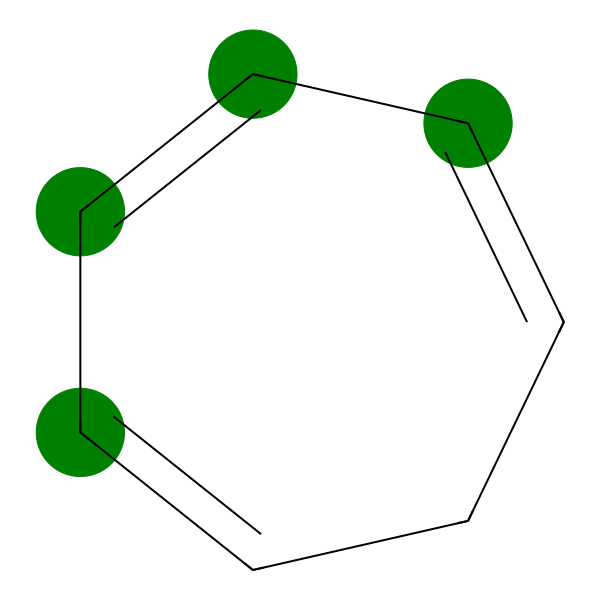

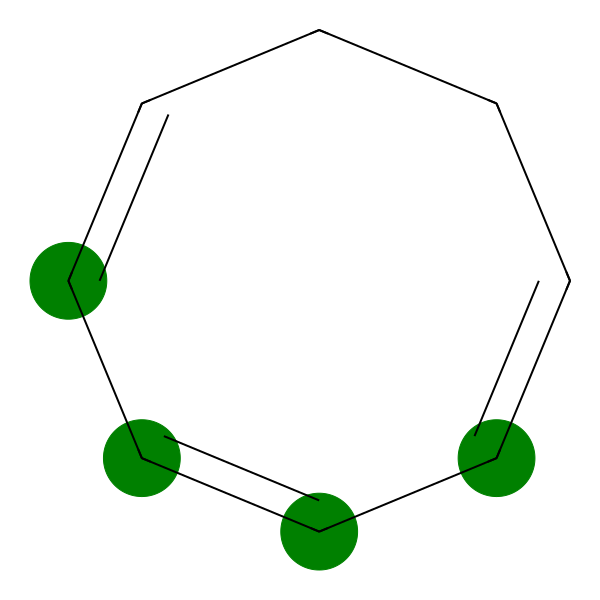

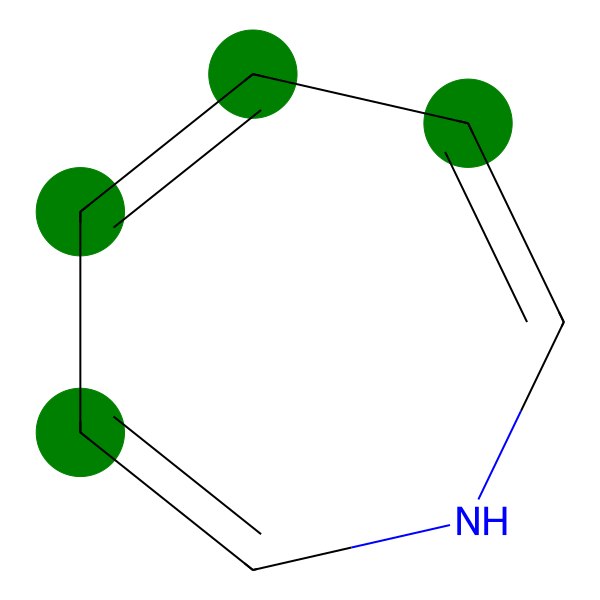

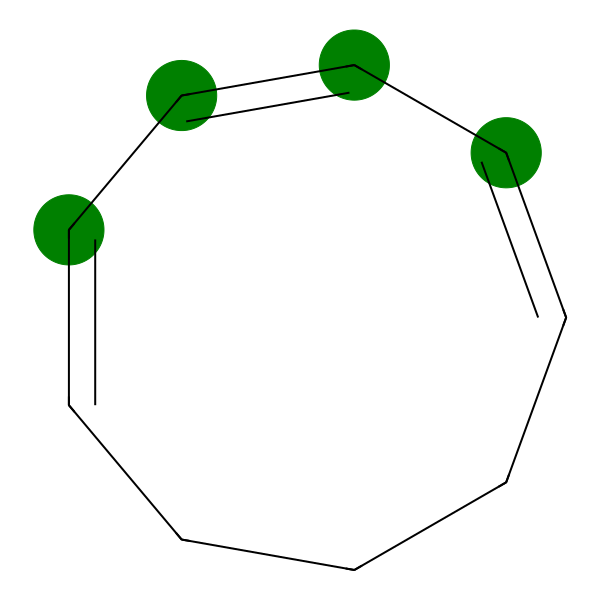

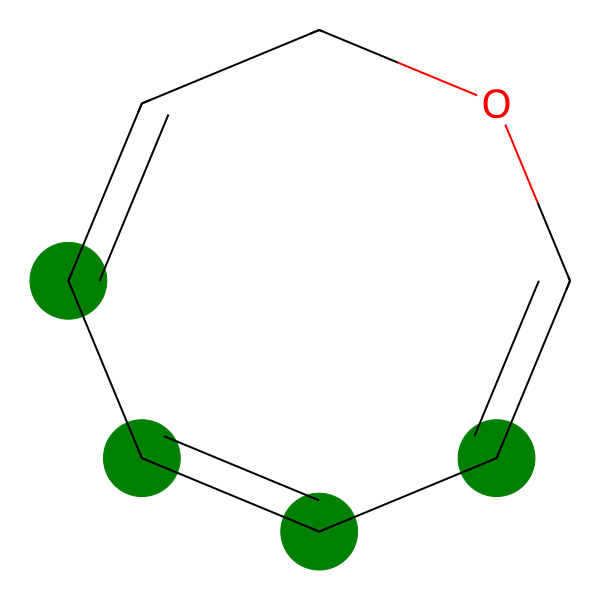

In [9]:
from IPython.display import Image

for img in image_list:
  display(img)